# Demo

A ride service company's team is interested in predicting which driver signups are most likely to start driving within the first 30 days of signup. To help explore this question, we have provided a sample dataset of a cohort of driver signups. The data was pulled a some time after they signed up to include the result of whether they actually completed their first trip. It also includes several pieces of background information gathered about the driver and their car.<br>

See below for a description of the dataset. Please include any queries or other code you wrote for the analysis and delete the dataset when you have finished with the challenge. Please also call out any data related assumptions or issues that you encounter.<br>

# Data set description<br>
id: driver_id<br>
city_name : city that this user signed up in<br>
signup_os : signup device of the user<br>
signup_channel : what channel did the driver sign up from<br>
signup_timestamp : timestamp of account creation<br>
bgc_date : timestamp when driver consented to background check<br>
vehicle_added_date : timestamp when driver’s vehicle information was uploaded<br>
vehicle_make: make of vehicle uploaded<br>
vehicle_model: model of vehicle uploaded<br>
vehicle_year: year that the car was made<br>
first_trip_date : timestamp of the first trip as a driver<br>

Part A<br>
Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the driver signups took a first trip within 30 days of signing up?<br>

Part B<br>
Create 3-5 charts to help the Driver team visualize key patterns in the data. Are there any patterns that appear to predict whether a signup will start to drive within 30 days of signing up?<br>

Part C<br>
Hypothesize how the company might leverage the insights gained from the data to generate more first trips.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from patsy.highlevel import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, tree
import graphviz
import os
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
#from pylab import rcParams

In [2]:
# read data and have a glance
df = pd.read_csv('D:/Google Drive/Demo/Demo_Dataset.csv')
df.head(5)

,id,city_name,signup_os,signup_channel,signup_timestamp,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_trip_timestamp
0,1,Strark,ios web,Paid,1/2/2016,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/2016,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/2016,1/11/2016,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/2016,2/3/2016,2/3/2016,Toyota,Corolla,2016.0,2/3/2016
4,5,Strark,android web,Referral,1/10/2016,1/25/2016,1/26/2016,Hyundai,Sonata,2016.0,NaN


In [3]:
len(df)

54681

In [4]:
# description
df.describe(include = 'all')

,id,city_name,signup_os,signup_channel,signup_timestamp,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_trip_timestamp
count,54681.000000,54681,47824,54681,54681,32896,13134,13223,13223,13223.000000,6137
unique,NaN,3,5,3,30,74,78,46,368,NaN,57
top,NaN,Strark,ios web,Paid,1/5/2016,1/29/2016,1/26/2016,Toyota,Civic,NaN,1/23/2016
freq,NaN,29557,16632,23938,2489,1125,377,3219,689,NaN,257
mean,27341.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010.568025,NaN
std,15785.189372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.219184,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
25%,13671.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008.000000,NaN
50%,27341.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013.000000,NaN
75%,41011.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015.000000,NaN


we check the data columns with null values and the numbers

In [5]:
list=[]
for col in df.columns:
    num_null = df[col].isnull().sum()
    if num_null > 0:
        print ('%s null values found in column: %s' % (num_null, col))
        list.append(col)

6857 null values found in column: signup_os
21785 null values found in column: bgc_date
41547 null values found in column: vehicle_added_date
41458 null values found in column: vehicle_make
41458 null values found in column: vehicle_model
41458 null values found in column: vehicle_year
48544 null values found in column: first_completed_trip_timestamp


Add come columns for future analysis. Use some common sense. think about what info might be useful.

In [6]:
# create completed first trip column
# bool: True or False, make use of the null values
df['completed_first_trip'] = df['first_completed_trip_timestamp'].notnull()
df['completed_first_trip'] = df['completed_first_trip'].astype(int)

# same thing goes for bgc, add vehicle, and both
df['completed_bgc'] = df['bgc_date'].notnull()
df['completed_add_vehicle'] = df['vehicle_added_date'].notnull()
df['completed_both_bgc_veh'] = df['completed_add_vehicle']&df['completed_bgc']

# create bool column for vehicle make info
# and column for signup referral 
df['vehicle_make_known'] = df['vehicle_make'].notnull()
df['signup_referral'] = df['signup_channel'] == 'Referral'

# datetime columns formatting
df['signup_timestamp'] = pd.to_datetime(df['signup_timestamp'])
df['bgc_date'] = pd.to_datetime(df['bgc_date'])
df['vehicle_added_date'] = pd.to_datetime(df['vehicle_added_date'])
df['first_completed_trip_timestamp'] = pd.to_datetime(df['first_completed_trip_timestamp'])

# Create time deltas (differences) columns
df['signup_to_bgc_days'] = (df['bgc_date'] - df['signup_timestamp']).dt.days
df['signup_to_vehicle_add_days'] = (df['vehicle_added_date'] - df['signup_timestamp']).dt.days
df['bgc_to_vehicle_added_days'] = (df['bgc_date'] - df['vehicle_added_date']).dt.days
df['signup_to_first_trip_days'] = (df['first_completed_trip_timestamp'] - df['signup_timestamp']).dt.days

In [7]:
# create weekday column
df['signup_weekday'] = df['bgc_date'].apply(lambda x: x.weekday() <= 4).astype(bool)

In [8]:
df.dtypes

id                                         int64
city_name                                 object
signup_os                                 object
signup_channel                            object
signup_timestamp                  datetime64[ns]
bgc_date                          datetime64[ns]
vehicle_added_date                datetime64[ns]
vehicle_make                              object
vehicle_model                             object
vehicle_year                             float64
first_completed_trip_timestamp    datetime64[ns]
completed_first_trip                       int32
completed_bgc                               bool
completed_add_vehicle                       bool
completed_both_bgc_veh                      bool
vehicle_make_known                          bool
signup_referral                             bool
signup_to_bgc_days                       float64
signup_to_vehicle_add_days               float64
bgc_to_vehicle_added_days                float64
signup_to_first_trip

# Part A
What fraction of the driver signups took a first trip within 30 days of signing up?
create percentage value

In [9]:
completed_first_trip_percentage = len(df[df['completed_first_trip'] >= 1])/len(df)
print ('Part A: The fraction of the driver signups took a first trip within 30 days of signing up is: %s ' % completed_first_trip_percentage)

Part A: The fraction of the driver signups took a first trip within 30 days of signing up is: 0.11223276823759624 


# Visualization

data cleaning
observe and check the dataframe visually see if there is anything abnormal

In [10]:
# observe there are 4 rows contain adding vehicles occured before signup.
# might due to data entry error
# exclude these records
# there are also vehicle added before bgc, but this is normal so we allow it.
# there is no negative signup_to_bgc_days so we don't worry about it
df = df.drop(df.index[df['signup_to_vehicle_add_days'] < 0])

# fill in to null values as "unknown" for these categorical columns
# might use them in the future
sublist = ['signup_os','signup_channel']
for col in sublist:
     df[col] = df[col].fillna('unknown')

# test if any null values still exist
print(df.isnull().values.any())
# export as csv file
df.to_csv('output.csv')

True


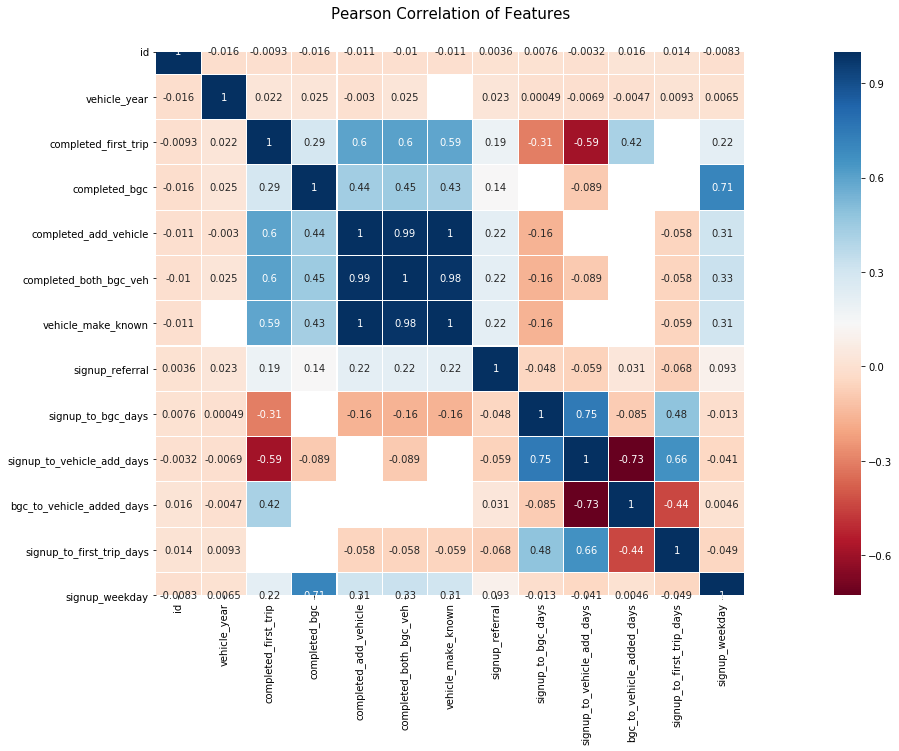

In [11]:
colormap = plt.cm.RdBu
plt.figure(figsize=(32,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
# Note that the categorical features have been neglected in the correlation matrix.
# the missing cells are automatically masked

the correlations between completed_first_trip and some variables are high. 

Generally Pearson Correlation does not deal with categorical variables. But 2 binary variables were considered continuous and calculate a kind of correlation. So it still makes sence here.

We will try boosting later, try to iteratively learning weak classifiers with respect to a distribution and adding them to a final strong classifier

Text(0.5, 1.0, 'Completed first trip distribution')

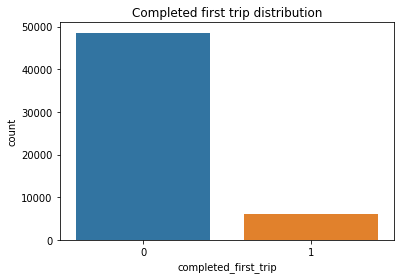

In [12]:
sns.countplot(x = "completed_first_trip",data = df)
plt.title("Completed first trip distribution")

Note that the classes are highly uneven , in order to model the data correctly, we can have an equal representation of both the classes using stratified sampling 

Text(0.5, 1.0, 'Weekday or not distribution')

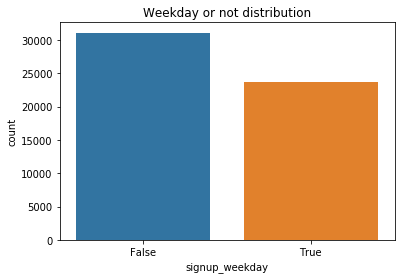

In [13]:
sns.countplot(x = "signup_weekday",data = df)
plt.title("Weekday or not distribution")

not too big difference

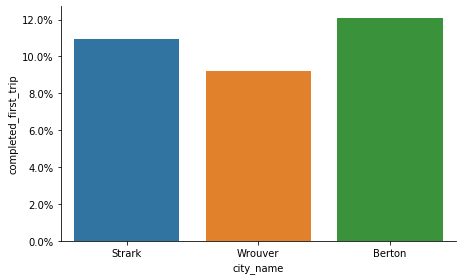

<Figure size 2304x720 with 0 Axes>

In [14]:
g = sns.catplot(x="city_name", y="completed_first_trip", data=df, \
               kind="bar", ci=None, aspect=1.6, height = 4) 
plt.figure(figsize=(32,10))
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

No big different patter observed among the 3 cities. I will not worry about using city_name as a classifier later

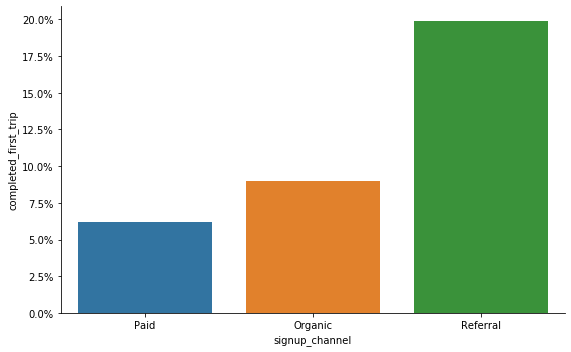

In [15]:
g = sns.catplot(x="signup_channel", y="completed_first_trip", data=df, \
               kind="bar", ci=None, aspect=1.6) 

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

referral drivers tend to complete their first trip

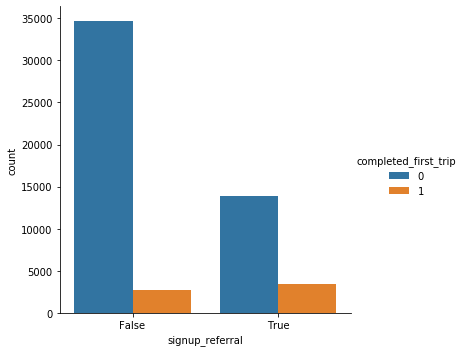

In [16]:
sns.catplot(x="signup_referral", hue="completed_first_trip", data=df, \
               kind="count")  

This is interesting. In all of the 3 cities, those signed up through referral are more likely to complete a first trip. This is why I created a dummy variable/column for sign_up_referral true or false. 

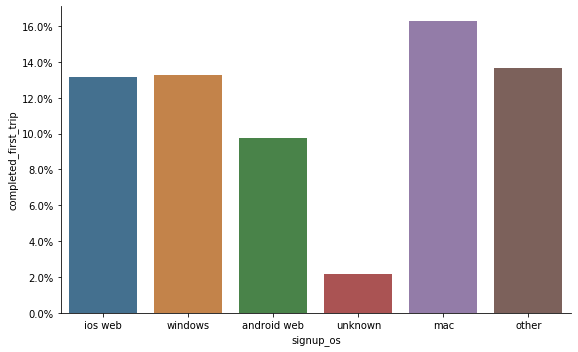

In [17]:
g = sns.catplot(x="signup_os", y="completed_first_trip", data=df, \
               saturation=.5, kind="bar", ci=None, aspect=1.6) 

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

mac has higher chance to complete a first trip. unknown has the lowest chance. but the difference is not big. 

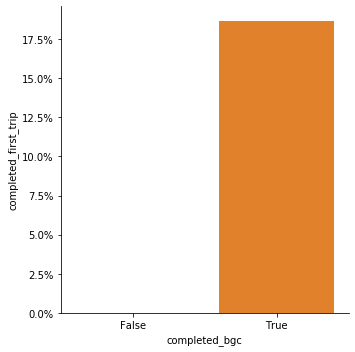

In [18]:
g = sns.catplot(x="completed_bgc", y="completed_first_trip", data=df, \
               kind="bar", ci=None, aspect=1) 

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Those who complete first trip all completed background check. makes sense. But keep in mind that among those completed background check, still a large percentage did not complete first trip.

Also tells us the bdc date missing is not at random.

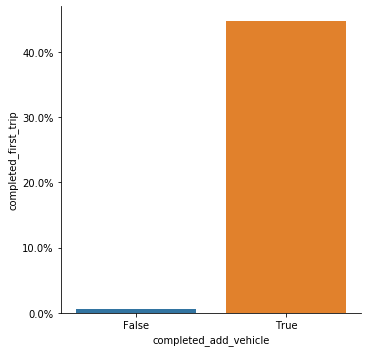

In [19]:
g = sns.catplot(x="completed_add_vehicle", y="completed_first_trip", data=df, \
               kind="bar", ci=None, aspect=1) 

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Those completed add vehicle are more likely to complete first trip. Also tells us the add vehicle missing is not at random.

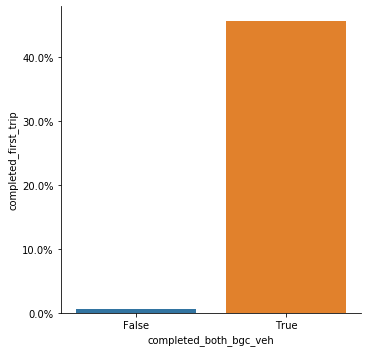

In [20]:
g = sns.catplot(x="completed_both_bgc_veh", y="completed_first_trip", data=df, \
               kind="bar", ci=None, aspect=1) 

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

Those completed both background check and add vehicle are more likely to complete first trip. makes sense. 

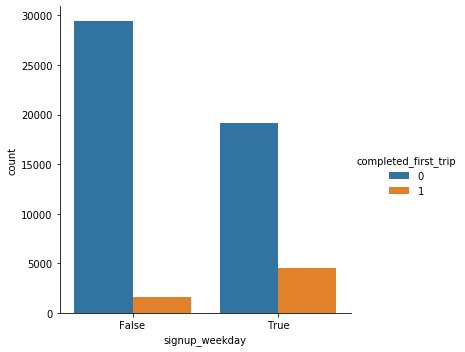

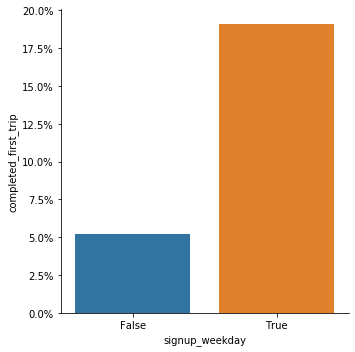

In [21]:
sns.catplot(x="signup_weekday", hue="completed_first_trip", data=df, \
               kind="count") 

g = sns.catplot(x="signup_weekday", y="completed_first_trip", data=df, \
               kind="bar", ci=None, aspect=1) 

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

more people signup on weekends in general, but for those signed up on weekdays, people are more likely to complete a first trip.

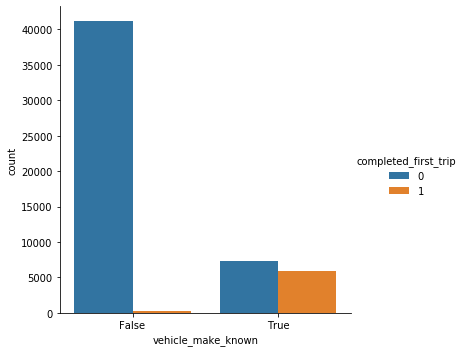

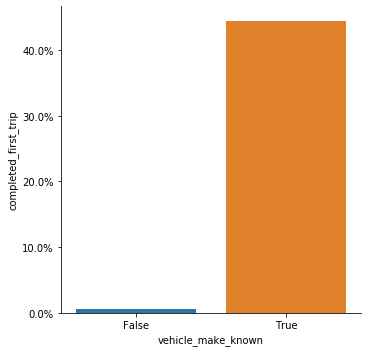

In [22]:
sns.catplot(x="vehicle_make_known", hue="completed_first_trip", data=df, \
               kind="count") 

g = sns.catplot(x="vehicle_make_known", y="completed_first_trip", data=df, \
               kind="bar", ci=None, aspect=1) 

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

when vehicle make is known, people are more likely to complete a first trip, than in vehicle make unknown catagory.

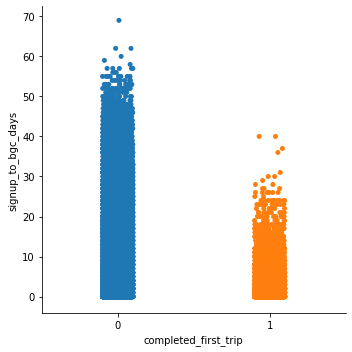

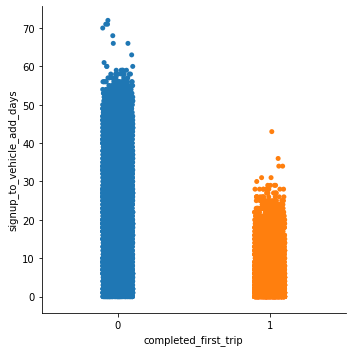

In [23]:
sns.catplot(x="completed_first_trip", y="signup_to_bgc_days", data=df)  
sns.catplot(x="completed_first_trip", y="signup_to_vehicle_add_days", data=df)  
#sns.catplot(x="completed_first_trip", y="bgc_to_vehicle_added_days", data=df)           

signup_to_bgc_days, bgc_to_vehicle_added_days are shorter in those who completed first trip.
Means those drivers completed bgc, add veh in a short time are more likely to complete a first trip

# Prediction
# prepare the data

In [24]:

# only choose columns I think are useful

df_new = df[['vehicle_year'
            , 'completed_first_trip'
            , 'completed_bgc'
            , 'completed_add_vehicle'
            , 'completed_both_bgc_veh'
            , 'vehicle_make_known'
            , 'signup_referral'
            , 'signup_weekday'
            , 'signup_to_bgc_days'
            , 'signup_to_vehicle_add_days'
            ,'bgc_to_vehicle_added_days'
            ]]
df_new.isnull().any()

vehicle_year                   True
completed_first_trip          False
completed_bgc                 False
completed_add_vehicle         False
completed_both_bgc_veh        False
vehicle_make_known            False
signup_referral               False
signup_weekday                False
signup_to_bgc_days             True
signup_to_vehicle_add_days     True
bgc_to_vehicle_added_days      True
dtype: bool

In [25]:
# export a copy for future use in case
df_new.to_csv('df_new.csv')

In [26]:
# have a glance at the description
df_new.describe(include = 'all')

,vehicle_year,completed_first_trip,completed_bgc,completed_add_vehicle,completed_both_bgc_veh,vehicle_make_known,signup_referral,signup_weekday,signup_to_bgc_days,signup_to_vehicle_add_days,bgc_to_vehicle_added_days
count,13222.000000,54680.000000,54680,54680,54680,54680,54680,54680,32895.000000,13133.000000,12878.000000
unique,NaN,NaN,2,2,2,2,2,2,NaN,NaN,NaN
top,NaN,NaN,True,False,False,False,False,False,NaN,NaN,NaN
freq,NaN,NaN,32895,41547,41802,41458,37364,31060,NaN,NaN,NaN
mean,2010.568144,0.112217,NaN,NaN,NaN,NaN,NaN,NaN,10.046755,15.204751,-7.136279
std,35.220513,0.315636,NaN,NaN,NaN,NaN,NaN,NaN,10.519705,14.064157,9.335954
min,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-55.000000
25%,2008.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,4.000000,-10.000000
50%,2013.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,11.000000,-4.000000
75%,2015.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,24.000000,-1.000000


We have nan in some columns
first I will try a model who can handle missing values
XGBoost (Extreme Gradient Boosting) belongs to a family of boosting algorithms 
and uses the gradient boosting (GBM) framework at its core. 
It is an optimized distributed gradient boosting library.
It can handle missing values

# stratified sampling

Text(0.5, 1.0, 'Class distribution after Stratified sampling')

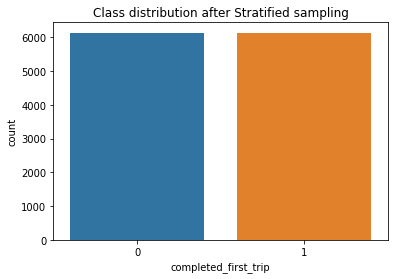

In [27]:
# Stratified sampling- Making sure that the data has equal representation from the 2 classes
y_0 = df_new[(df_new.completed_first_trip==0)]
y_1 = df_new[(df_new.completed_first_trip==1)]
n = min(len(y_0),len(y_1))
y_0 = y_0.sample(n = n, random_state = 0)
y_1 = y_1.sample(n = n, random_state = 0)
df_strat = pd.concat([y_0, y_1])

# Checking the class_distribution :
sns.countplot(x = "completed_first_trip",data = df_strat)
plt.title("Class distribution after Stratified sampling")

In [28]:
# pass stratified df
df_new = df_strat

In [29]:
# creating predictor and response variables
y = df_new.completed_first_trip
X = df_new.drop('completed_first_trip',axis=1)

#splitting the data in training and test sizes
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

In [30]:
# check the data type
df_new.dtypes

vehicle_year                  float64
completed_first_trip            int32
completed_bgc                    bool
completed_add_vehicle            bool
completed_both_bgc_veh           bool
vehicle_make_known               bool
signup_referral                  bool
signup_weekday                   bool
signup_to_bgc_days            float64
signup_to_vehicle_add_days    float64
bgc_to_vehicle_added_days     float64
dtype: object

# use scikit-learn package

# xgboost 
XGBoost (Extreme Gradient Boosting) belongs to a family of boosting algorithms 
and uses the gradient boosting (GBM) framework at its core. 
It is an optimized distributed gradient boosting library.
It can handle missing values

In [31]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state = 0)
model.fit(X_train, y_train)
s_xgboost = model.score(X_test, y_test)
print(s_xgboost)

0.9364562118126273


xgboost provides a score above

# Deal with missing(nan) values : imputation

Now let's do some imputation with the missing values "nan" and run some other models.
Things I tried here are:
1. Likewise deletion (drop nan)
2. Single imputation
    2.1 fill nan with mean 
    2.2 fill nan with 100 
    2.3 fill nan with max
3. multiple imputation
    MICE in R 

From observation I think the missing value in my data is not "missing at random".
Also, we observe before the missing percentage is very high.
No. 1 will cause biased results, and decrease the power of the prediction by decreasing the effective sample size more than half.

No. 2 will cause biased results and doesn't really make sense in our dataset. 
For example, some drivers missing background check date still completed a first trip in the end.
But from the plots we made before, we can see those drivers who have a background check date are more likely to complete a first trip.

No. 3 averages the outcomes across multiple imputed data sets. It aims to allow for the uncertainty about the missing data by creating several different plausible imputed data sets and appropriately combining results obtained from each of them. For example, the mice package in R, helps you imputing missing values with plausible data values. These plausible values are drawn from a distribution specifically designed for each missing datapoint. This seems like the best option, but I tried them all anyways. ("fancyimpute" and "sklearn IterativeImputer" in python also gives you multiple options to deal with this but I never got those work on my PC so I only tried MICE.)

In [32]:
# method 1, drop na
df_new=df_new.dropna()

# method 2.1, fill na with mean
#df_new=df_new.fillna(df_new.mean())

# method 2.2, fill na with 100
#df_new=df_new.fillna(100)


# method 2.3, fill nan with max
#from sklearn.impute import SimpleImputer

# method 3, Multivariate Imputation
# unfortunately the IterativeImputer in python could not be imported successfully on my PC. 
# this is a new feature recently added, this might be ther reason
# simple imputor works tho, which we already tried the methods
# I tried "mice" package in R to do Multivariate Imputation. score does not improve much.

#import numpy as np
#from sklearn.impute import IterativeImputer
#imp = Imputer.IterativeImputer(max_iter=10, random_state=0)
#X_new = imp.fit(X) 

len(df_new)

6795

In [33]:
df_new.isnull().any()

vehicle_year                  False
completed_first_trip          False
completed_bgc                 False
completed_add_vehicle         False
completed_both_bgc_veh        False
vehicle_make_known            False
signup_referral               False
signup_weekday                False
signup_to_bgc_days            False
signup_to_vehicle_add_days    False
bgc_to_vehicle_added_days     False
dtype: bool

No missing values anymore. Great. Bad news is we lost more than half of the data. Now the size is really small. now let's update y and X with the new df_new without any missing values

In [34]:
# creating predictor and response variables
y = df_new.completed_first_trip
X = df_new.drop('completed_first_trip',axis=1)

#splitting the data in train and test 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

# Other methods
Logistic Regression was then chosen because I am predicting a binary dependent variable (whether complete first trip or not). I should not use Linear Regression or Polynomial Regression or some other common regression due to the dependent variable type.

Support Vector Machine (SVM) was also chosen, which is an algorithm used for classification problems similar to Logistic Regression (LR). LR and SVM with linear Kernel generally perform comparably in practice.

I also tested some other models. 

# LogisticRegression
# KNeighborsClassifier
# C-Support Vector Classification
# Multi-layer Perceptron classifier
# Decision tree
# Random forest

In [35]:
# LogisticRegression
clf_lr = LogisticRegression(solver = "lbfgs", random_state = 0)
clf_lr.fit(X_train, y_train)
s_LogReg = clf_lr.score(X_test, y_test)
print('LogisticRegression score:', s_LogReg)


# KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
s_knn = knn.score(X_test, y_test)
print('KNeighborsClassifier score:',s_knn )

# C-Support Vector Classification
svc = svm.SVC(gamma = "auto", random_state = 10)
svc.fit (X_train, y_train)
s_svc = svc.score(X_test, y_test)
print('svm score:', s_svc)

# Multi-layer Perceptron classifier
mc = MLPClassifier(random_state = 10)
mc.fit(X_train, y_train)
s_MLP = mc.score(X_test, y_test)
print('MLPClassifier score:',s_MLP)

# decision tree
clf = tree.DecisionTreeClassifier(random_state = 10)
clf.fit(X_train, y_train)
s_dt =  clf.score(X_test, y_test)
print('Decision Tree score:',s_dt)

# decision tree plot
# generate and open a .pdf file
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'
tree.export_graphviz(clf, out_file = 'tree.dot')
dot_data = tree.export_graphviz(clf, out_file = None, feature_names = X.columns)
graph = graphviz.Source(dot_data)
graph.render('clf',view=True)

# random forest
clf_rf = RandomForestClassifier(n_estimators=10, random_state = 10)
clf_rf.fit(X_train, y_train)
s_rf = clf_rf.score(X_test, y_test)
print('RandomForestClassifier score:', s_rf)

LogisticRegression score: 0.9094922737306843
KNeighborsClassifier score: 0.9102281089036056
svm score: 0.9139072847682119
MLPClassifier score: 0.8763796909492274
Decision Tree score: 0.8675496688741722
RandomForestClassifier score: 0.8881530537159676


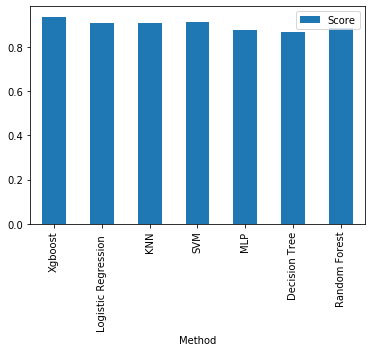

In [36]:
# generate graphs
p_list = []
p_list.append(['Xgboost', s_xgboost])
p_list.append(['Logistic Regression ', s_LogReg])
p_list.append(['KNN', s_knn])
p_list.append(['SVM', s_svc])
p_list.append(['MLP', s_MLP])
p_list.append(['Decision Tree', s_dt])
p_list.append(['Random Forest', s_rf])

perf_df = pd.DataFrame(p_list, columns = ['Method', 'Score'])
perf_df.plot(x = "Method", y = "Score", kind = "bar")

# use statsmodels package

In [37]:
# get df_new again with those nan values
df_new = df[['vehicle_year'
            , 'completed_first_trip'
            , 'completed_bgc'
            , 'completed_add_vehicle'
            , 'completed_both_bgc_veh'
            , 'vehicle_make_known'
            , 'signup_referral'
            , 'signup_weekday'
            , 'signup_to_bgc_days'
            , 'signup_to_vehicle_add_days'
            ,'bgc_to_vehicle_added_days'
            ]]
df_new.isnull().any()

vehicle_year                   True
completed_first_trip          False
completed_bgc                 False
completed_add_vehicle         False
completed_both_bgc_veh        False
vehicle_make_known            False
signup_referral               False
signup_weekday                False
signup_to_bgc_days             True
signup_to_vehicle_add_days     True
bgc_to_vehicle_added_days      True
dtype: bool

In [38]:
def run_sm(train, test, model):

    # train and test, X and y split
    y_train, X_train = dmatrices(model, data=train, return_type='dataframe', NA_action='drop')
    y_test, X_test = dmatrices(model, data=test, return_type='dataframe', NA_action='drop')

    # fit model
    m = sm.Logit(y_train, X_train)
    mfit = m.fit()

    # print results
    print (mfit.summary())
    print ('AIC:',mfit.aic)
    print ('BIC:',mfit.bic)
    predicted = mfit.predict(X_test)
    auc = roc_auc_score(y_true=y_test, y_score=predicted)
    print ('AUC for test: %s' %auc)

In [39]:
# Train test split
train = df_new.sample(frac = 0.8, random_state = 0)
test = df_new.drop(train.index)

# play with different variable combinations

In [40]:
# Run logistic regression models
# try different variable combinations by editing the # in each line. they all stay below 0.6 accuracy tho.
run_sm(train, test, 'completed_first_trip ~ '
                       'vehicle_year'                   
#                       '+ completed_bgc'
#                       '+ completed_add_vehicle'
#                       '+ completed_both_bgc_veh'
#                       '+ vehicle_make_known'
                       '+ signup_referral'
#                       '+ signup_weekday'
                       '+ signup_to_bgc_days'
#                       '+ signup_to_vehicle_add_days'
#                       '+ bgc_to_vehicle_added_days'
                       )

Optimization terminated successfully.
         Current function value: 0.550844
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     completed_first_trip   No. Observations:                10312
Model:                            Logit   Df Residuals:                    10308
Method:                             MLE   Df Model:                            3
Date:                  Mon, 11 Nov 2019   Pseudo R-squ.:                  0.2007
Time:                          10:41:05   Log-Likelihood:                -5680.3
converged:                         True   LL-Null:                       -7106.8
Covariance Type:              nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -42.2388     11.226     -3.763      0.00

In [41]:
# Run logistic regression models
# try different variable combinations by editing the # in each line. they all stay below 0.6 accuracy tho.
run_sm(train, test, 'completed_first_trip ~ '
                       'vehicle_year'                   
#                       '+ completed_bgc'
#                       '+ completed_add_vehicle'
#                       '+ completed_both_bgc_veh'
#                       '+ vehicle_make_known'
                       '+ signup_referral'
#                       '+ signup_weekday'
#                       '+ signup_to_bgc_days'
                       '+ signup_to_vehicle_add_days'
#                       '+ bgc_to_vehicle_added_days'
                       )

Optimization terminated successfully.
         Current function value: 0.453170
         Iterations 8
                            Logit Regression Results                            
Dep. Variable:     completed_first_trip   No. Observations:                10512
Model:                            Logit   Df Residuals:                    10508
Method:                             MLE   Df Model:                            3
Date:                  Mon, 11 Nov 2019   Pseudo R-squ.:                  0.3408
Time:                          10:41:05   Log-Likelihood:                -4763.7
converged:                         True   LL-Null:                       -7226.6
Covariance Type:              nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -52.7487     12.476     -4.228 

In [42]:
# Run logistic regression models
# try different variable combinations by editing the # in each line. they all stay below 0.6 accuracy tho.
run_sm(train, test, 'completed_first_trip ~ '
                       'vehicle_year'                   
#                       '+ completed_bgc'
#                       '+ completed_add_vehicle'
#                       '+ completed_both_bgc_veh'
#                       '+ vehicle_make_known'
                       '+ signup_referral'
#                       '+ signup_weekday'
#                       '+ signup_to_bgc_days'
#                       '+ signup_to_vehicle_add_days'
                       '+ bgc_to_vehicle_added_days'
                       )

Optimization terminated successfully.
         Current function value: 0.562617
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     completed_first_trip   No. Observations:                10303
Model:                            Logit   Df Residuals:                    10299
Method:                             MLE   Df Model:                            3
Date:                  Mon, 11 Nov 2019   Pseudo R-squ.:                  0.1837
Time:                          10:41:05   Log-Likelihood:                -5796.6
converged:                         True   LL-Null:                       -7101.2
Covariance Type:              nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -55.2118     11.033     -5.004    

In [43]:
# Run logistic regression models
# try different variable combinations by editing the # in each line. they all stay below 0.6 accuracy tho.
run_sm(train, test, 'completed_first_trip ~ '
                       'vehicle_year'                   
#                       '+ completed_bgc'
#                       '+ completed_add_vehicle'
#                       '+ completed_both_bgc_veh'
#                       '+ vehicle_make_known'
                       '+ signup_referral'
                       '+ signup_weekday'
                       '+ signup_to_bgc_days'
#                       '+ signup_to_vehicle_add_days'
#                       '+ bgc_to_vehicle_added_days'
                       )

Optimization terminated successfully.
         Current function value: 0.550768
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     completed_first_trip   No. Observations:                10312
Model:                            Logit   Df Residuals:                    10307
Method:                             MLE   Df Model:                            4
Date:                  Mon, 11 Nov 2019   Pseudo R-squ.:                  0.2008
Time:                          10:41:05   Log-Likelihood:                -5679.5
converged:                         True   LL-Null:                       -7106.8
Covariance Type:              nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -42.4994     11.229     -3.785      0.00

In [44]:
# Run logistic regression models
# try different variable combinations by editing the # in each line. they all stay below 0.6 accuracy tho.
run_sm(train, test, 'completed_first_trip ~ '
                       'vehicle_year'                   
#                       '+ completed_bgc'
                       '+ completed_add_vehicle'
#                       '+ completed_both_bgc_veh'
#                       '+ vehicle_make_known'
                       '+ signup_referral'
#                       '+ signup_weekday'
                       '+ signup_to_bgc_days'
#                       '+ signup_to_vehicle_add_days'
#                       '+ bgc_to_vehicle_added_days'
                       )

Optimization terminated successfully.
         Current function value: 0.550703
         Iterations 7
                            Logit Regression Results                            
Dep. Variable:     completed_first_trip   No. Observations:                10312
Model:                            Logit   Df Residuals:                    10307
Method:                             MLE   Df Model:                            4
Date:                  Mon, 11 Nov 2019   Pseudo R-squ.:                  0.2009
Time:                          10:41:05   Log-Likelihood:                -5678.9
converged:                         True   LL-Null:                       -7106.8
Covariance Type:              nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       -44.0834     11.294   

# Summary

Assumption: 
-------------------------------------
If the first_completed_trip_timestamp is missing (null) then the first trip is not complete

I created some additional columns, details are in the procedures above. 

for example, I created a completed_bgc column from the bgc date column. (but I also noticed there are bgc_date is missing (null) drivers who completed the first trip. I think bgc is required for the driver to proceed further steps. 


Part A
-------------------------------------
Part A: The fraction of the driver signups took a first trip within 30 days of signing up is: 0.11223276823759624 


Part B
-------------------------------------
The dataset has a total length of 54K and contains large amount of missing values 41K

I tried boosting and imputation.

xgboost was first tested becaseu it contains boosting and can handle missing values.

Three methods were tested on dealing with the missing values: (details in previous pages)
1. Likewise deletion (drop nan)<br> 
2. Single imputation 2.1 fill nan with mean 2.2 fill nan with 100 2.3 fill nan with max<br> 
3. multiple imputation MICE in R<br> 

Logistic Regression was then chosen because I am predicting a binary dependent variable (whether complete first trip or not). I should not use Linear Regression or Polynomial Regression or some other common regression due to the dependent variable type.

Support Vector Machine (SVM) was also chosen, which is an algorithm used for classification problems similar to Logistic Regression (LR). LR and SVM with linear Kernel generally perform comparably in practice. 

I also tested some other models. In all the models, I used 80% data for training and 20% for testing. The accuracy scores are listed as follows:

LogisticRegression score: 0.9094922737306843<br> 
KNeighborsClassifier score: 0.9102281089036056<br> 
svm score: 0.9139072847682119<br> 
MLPClassifier score: 0.8763796909492274<br> 
Decision Tree score: 0.8675496688741722<br> 
RandomForestClassifier score: 0.8881530537159676<br> 

different combinations of input variables were tested. statsmodels.api were then used for logistic regression because it provides a very detailed report. Different combinations of input variables were tested. AIC, BIC, and AUC acores were calculated. A lower AIC or BIC means a better model. The AUC score were about the same among the different variable combinations.

One thing we can try is using different setttings/parameters in the imputation and regression/learning models. Although MICE was tried to complete multiple imputation, we might get better results after using different settings/parameters.

Part C
-------------------------------------
from the graphs, logistic regressions coefficients (tells the result change in log odds) and P values, and decision tree graphs, we can generate: 
1. Referral has a large positive impact on completing a first trip. The company could increase incentives for referral to arrtact more drivers referring each other and complete a first trip
2. vehicle_year has a positive impact on completing a first trip. The company could send out more reminders to drivers who has older vehicles to remind them to complete a first trip. 
3. signup_to_bgc_days, bgc_to_vehicle_added_days, signup_to_vehicle_add_days all have negative impact on completing a first trip. This means the longer the drivers wait to add vehicle, and background check, the less likely they will complete a first trip. The company could sent out reminders to those signed up drivers who hasn't completed these two more frequently to remind them to complete them.

